In [15]:

#importing libraries
import numpy as np
import pandas as pd
#keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from keras.wrappers.scikit_learn import KerasClassifier




from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
from keras import Sequential
from keras import regularizers
from keras.layers import Dropout
from keras.utils import to_categorical

# for combining all the hyper-parameters
import itertools 
from time import time
from keras import initializers

In [14]:
# reading training and testing data from the csv file
train_df = pd.read_csv ('../data/monks-3-test.csv',header=None).to_numpy()
test_df = pd.read_csv ('../data/monks-3-train.csv',header=None).to_numpy()

In [13]:
#Preparing train_df for training
train_set = train_df[:, 1:7]
train_label = train_df[:, 0]


#Preparing test_df for testing
test_set = test_df[:, 1:7]
test_label = test_df[:, 0]

In [4]:
 test_set.shape ,test_label.shape , train_set.shape , train_label.shape

((122, 6), (122,), (432, 6), (432,))

In [5]:
# one hot encoding 
from keras.utils import to_categorical

def fix_zero(dataset):
  return dataset - 1

def to_one_hot_encoding(dataset):
    fixed_dataset = fix_zero(dataset)
    one_hot_dataset = []
    for column in fixed_dataset.T:
        one_hot_column = to_categorical(column)
        for column_index in range(one_hot_column.shape[1]):
            one_hot_dataset.append(one_hot_column[:,column_index])
    return np.asarray(one_hot_dataset).T

In [6]:
one_hot_train = to_one_hot_encoding(train_set)
one_hot_test  = to_one_hot_encoding(test_set)
one_hot_train.shape , train_label.shape ,one_hot_test.shape , test_label.shape

((432, 17), (432,), (122, 17), (122,))

In [94]:
def create_model(
                    lr=0.1, 
                    num_hidden_units=3,
                    num_hidden_units2=3,
                    activation_hidden="relu", 
                    activation_hidden2="relu", 
                    activation_out="sigmoid",
                    momentum=0.7, 
                    decay=0.01
                ):
    # create model
    model = Sequential()
    initializer = initializers.GlorotNormal(seed=1) # has the parameter of seed to produce the same random sample.
    model.add(Dense(units=num_hidden_units, kernel_initializer=initializer, input_dim=17, activation=activation_hidden))
    model.add(Dense(units = num_hidden_units2,activation = activation_hidden2))
    model.add(Dense(1, activation=activation_out)) 

    #optimizer
    sgd = SGD(lr=lr, momentum=momentum, nesterov=False)  # We can add decay to hyper parameter list to get optimum value. 

    # Compile model
    model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['accuracy'])
    return model

In [8]:
# screening 
def plot_accuracy_two_params(history, par_a, value_a, par_b, value_b, axs):
    plt.subplot(axs)
    plt.plot(history.history['accuracy'], label='TR_set')
    plt.plot(history.history['val_accuracy'], label='VL_set')
    axs.set_title('Model Accuracy [' + par_a + ' = ' + str(value_a) + '] [' + par_b + ' = ' + str(value_b) + ']' )
    axs.set_ylabel('Accuracy')
    axs.set_xlabel('Epoch')
    axs.legend(loc='best')

def plot_loss_two_params(history, par_a, value_a, par_b, value_b, axs):
    plt.subplot(axs)
    plt.plot(history.history['loss'], label='TR_set')
    plt.plot(history.history['val_loss'], label='VL_set')
    axs.set_title('Model Loss (MSE) [' + par_a + ' = ' + str(value_a) + '] [' + par_b + ' = ' + str(value_b) + ']' )
    axs.set_ylabel('MSE')
    axs.set_xlabel('Epoch')
    axs.legend(loc='best')

def screening_phase(par_a, values_a, par_b, values_b, plot_function=plot_loss_two_params):
    num_values_a = len(values_a)
    num_values_b = len(values_b)
    f, axs = plt.subplots(nrows= num_values_a, ncols=num_values_b, figsize=(8*num_values_b, 5*num_values_a))
    for i in range(num_values_a):
        for j in range(num_values_b):
            params = {par_a : values_a[i], par_b : values_b[j]}
            model = KerasClassifier(build_fn=create_model, **params)
            history = model.fit(one_hot_train, train_label, validation_data=(one_hot_test, test_label), epochs=90, batch_size=10, verbose=0)
            plot_function(history, par_a, values_a[i], par_b, values_b[j], axs[i][j])
    plt.suptitle('Screening phase on ' + par_a + ' and ' + par_b)
    plt.show()



screening phase to fined num_hidden_units and activation_out 

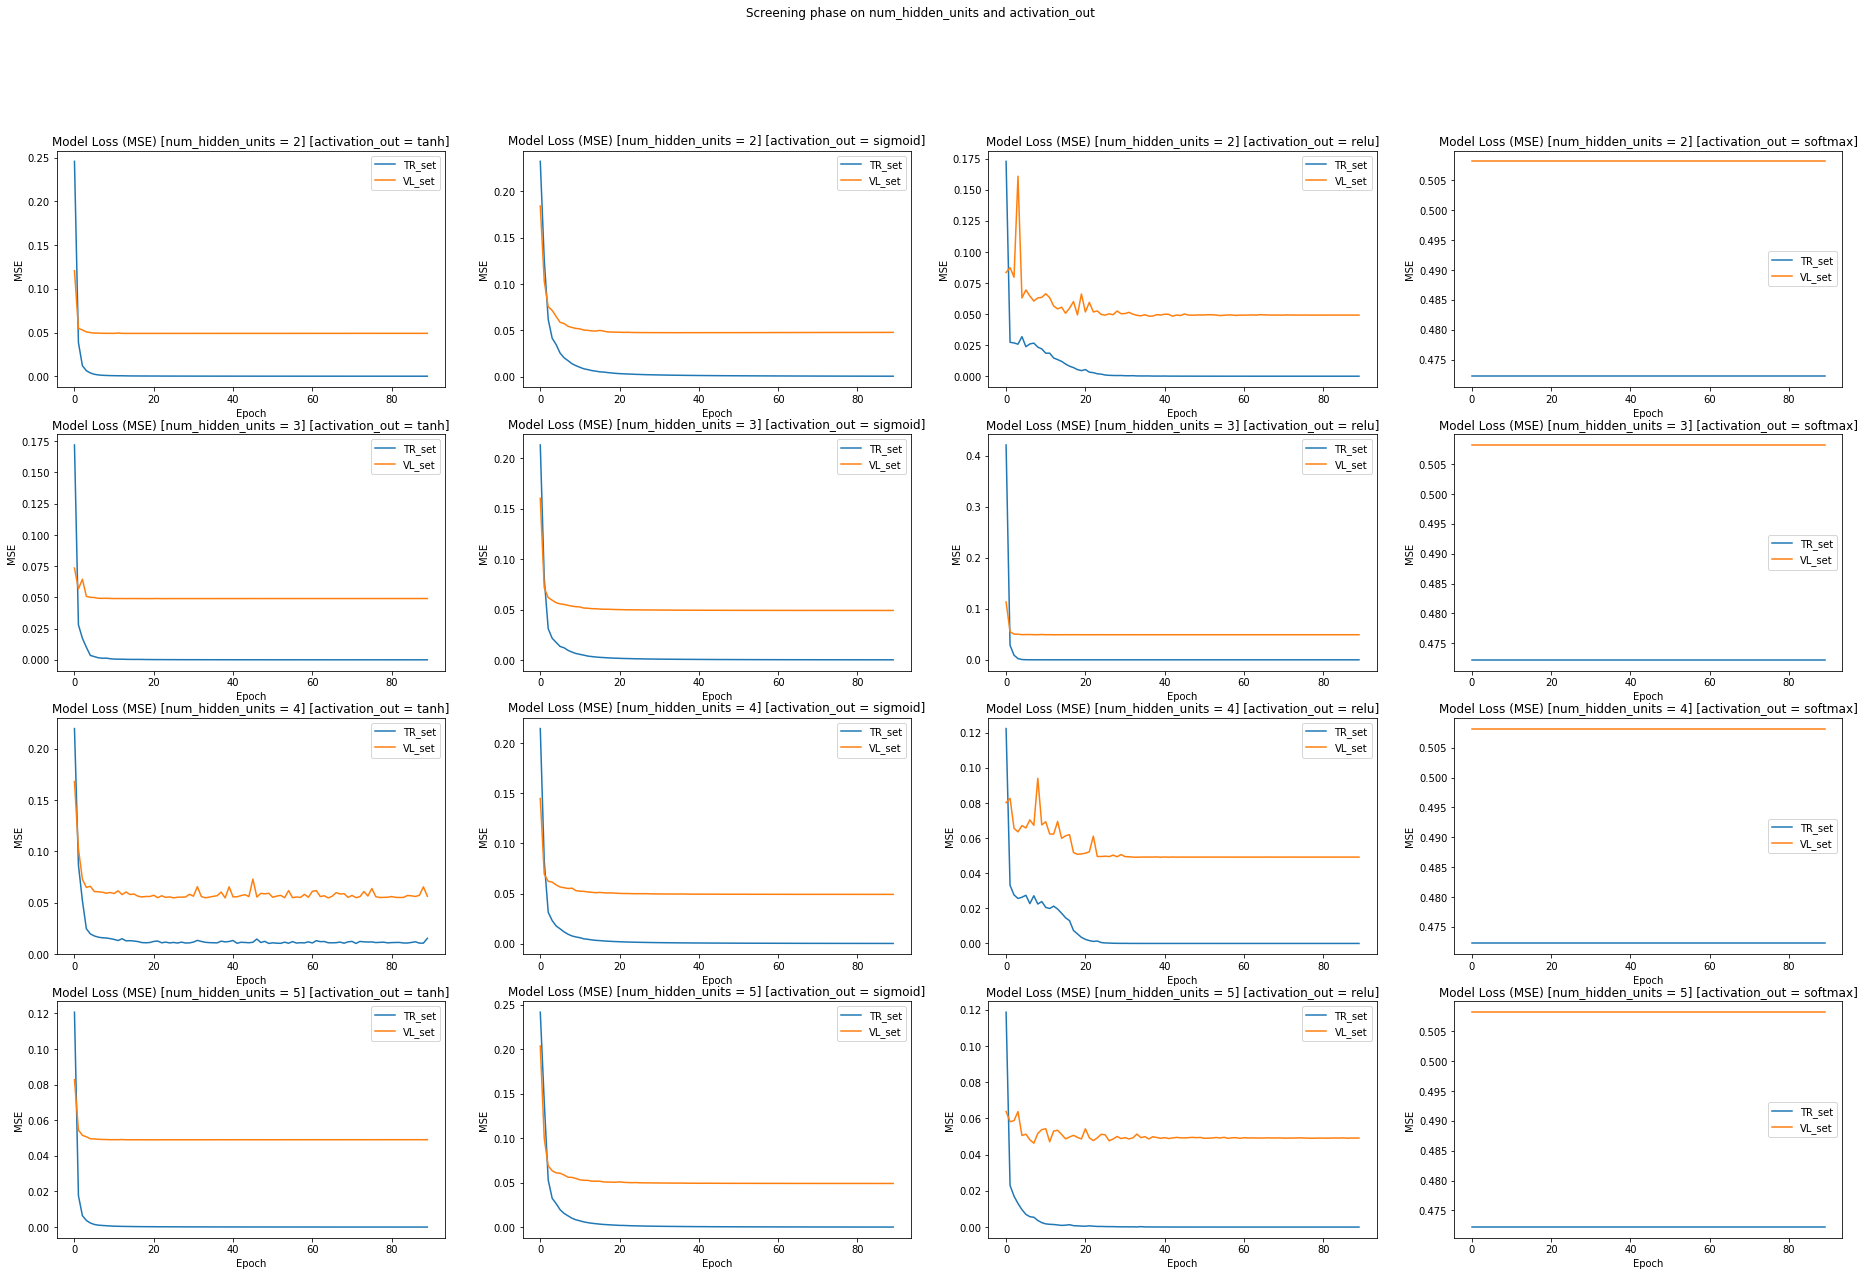

In [10]:
screening_phase( 'num_hidden_units', [2,3,4,5],'activation_out', ['tanh','sigmoid','relu','softmax'])

activation-out = sigmoid and num_hidden_units = 3

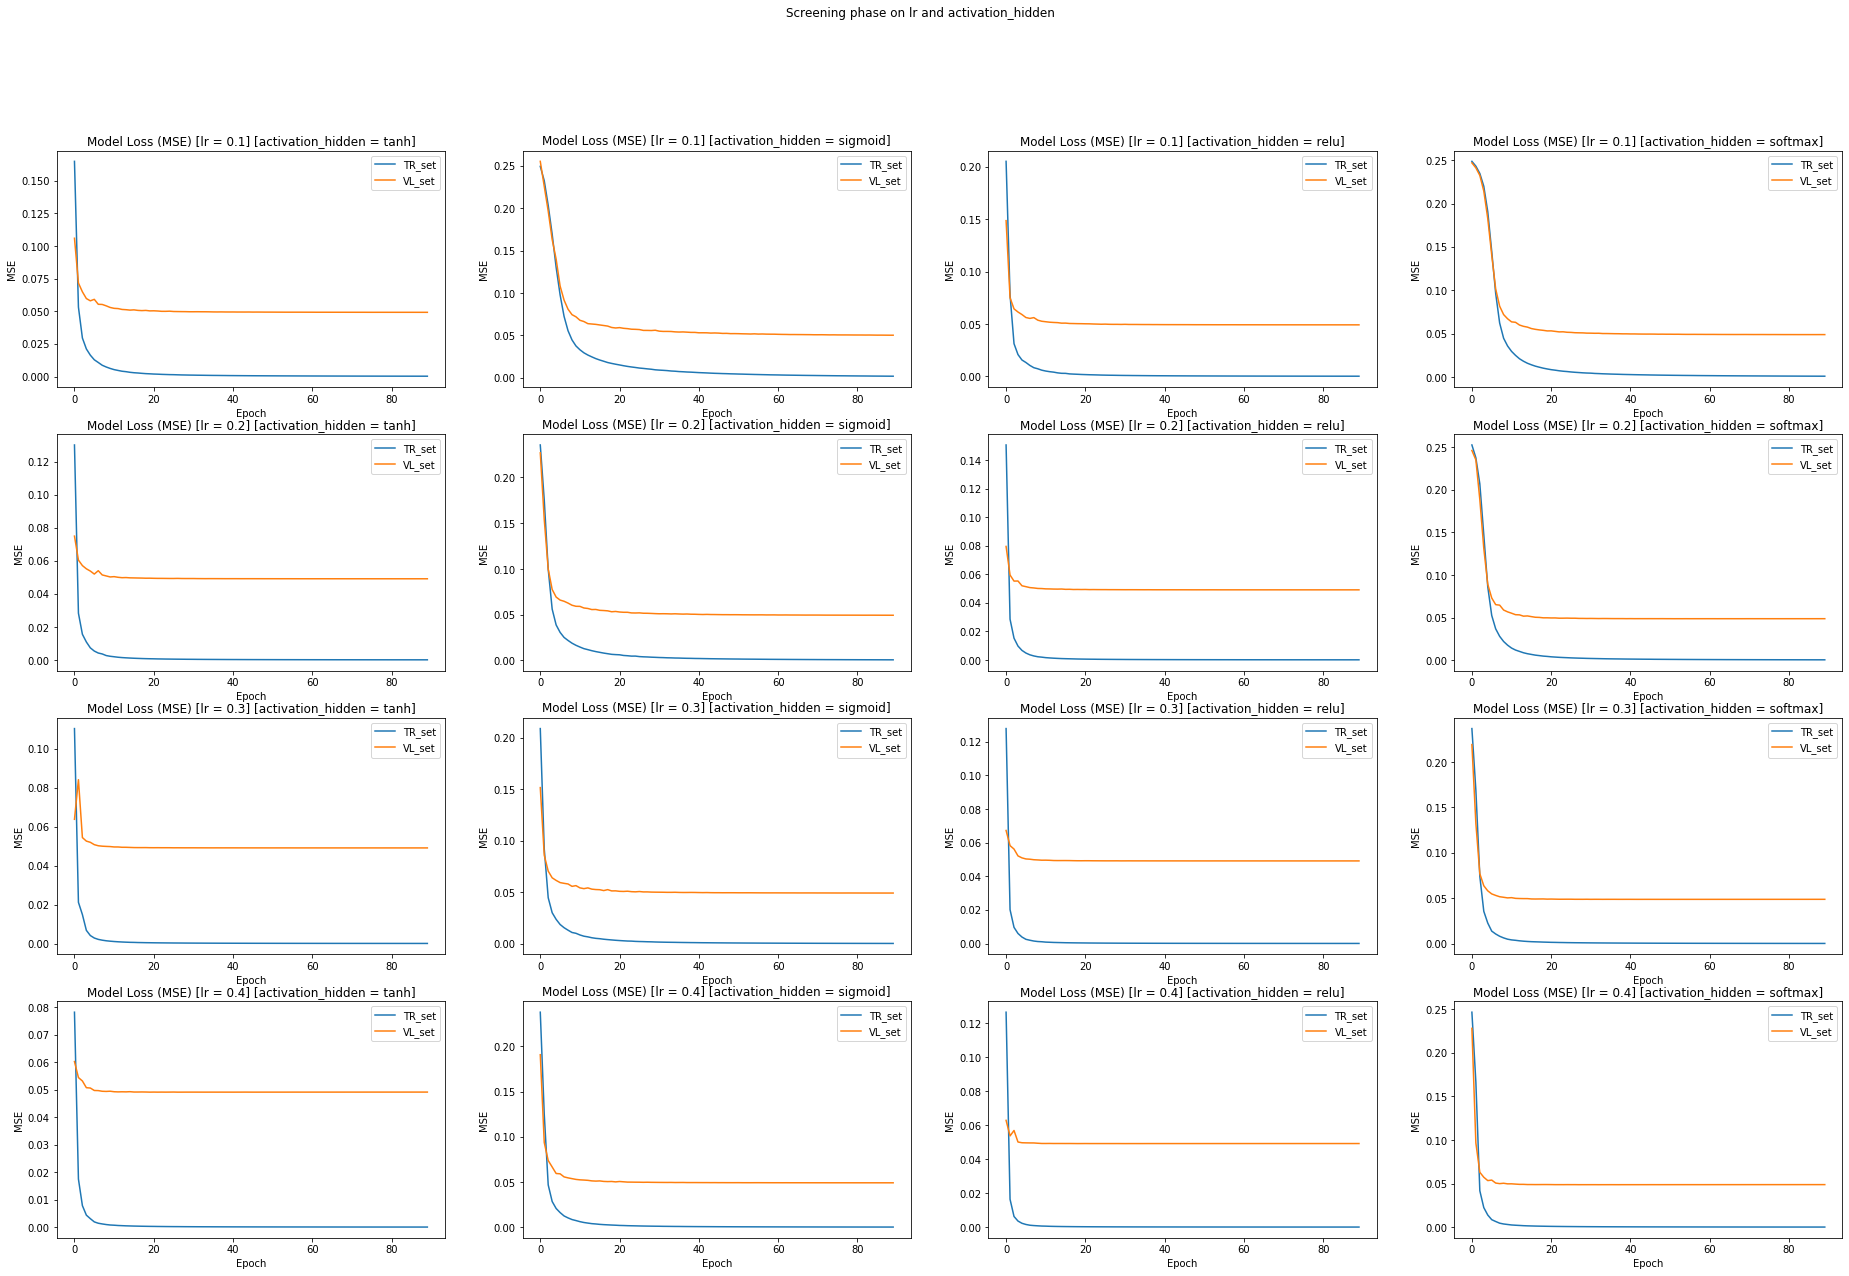

In [11]:
screening_phase('lr', [0.1,0.2,0.3,0.4], 'activation_hidden', ['tanh','sigmoid','relu','softmax'])

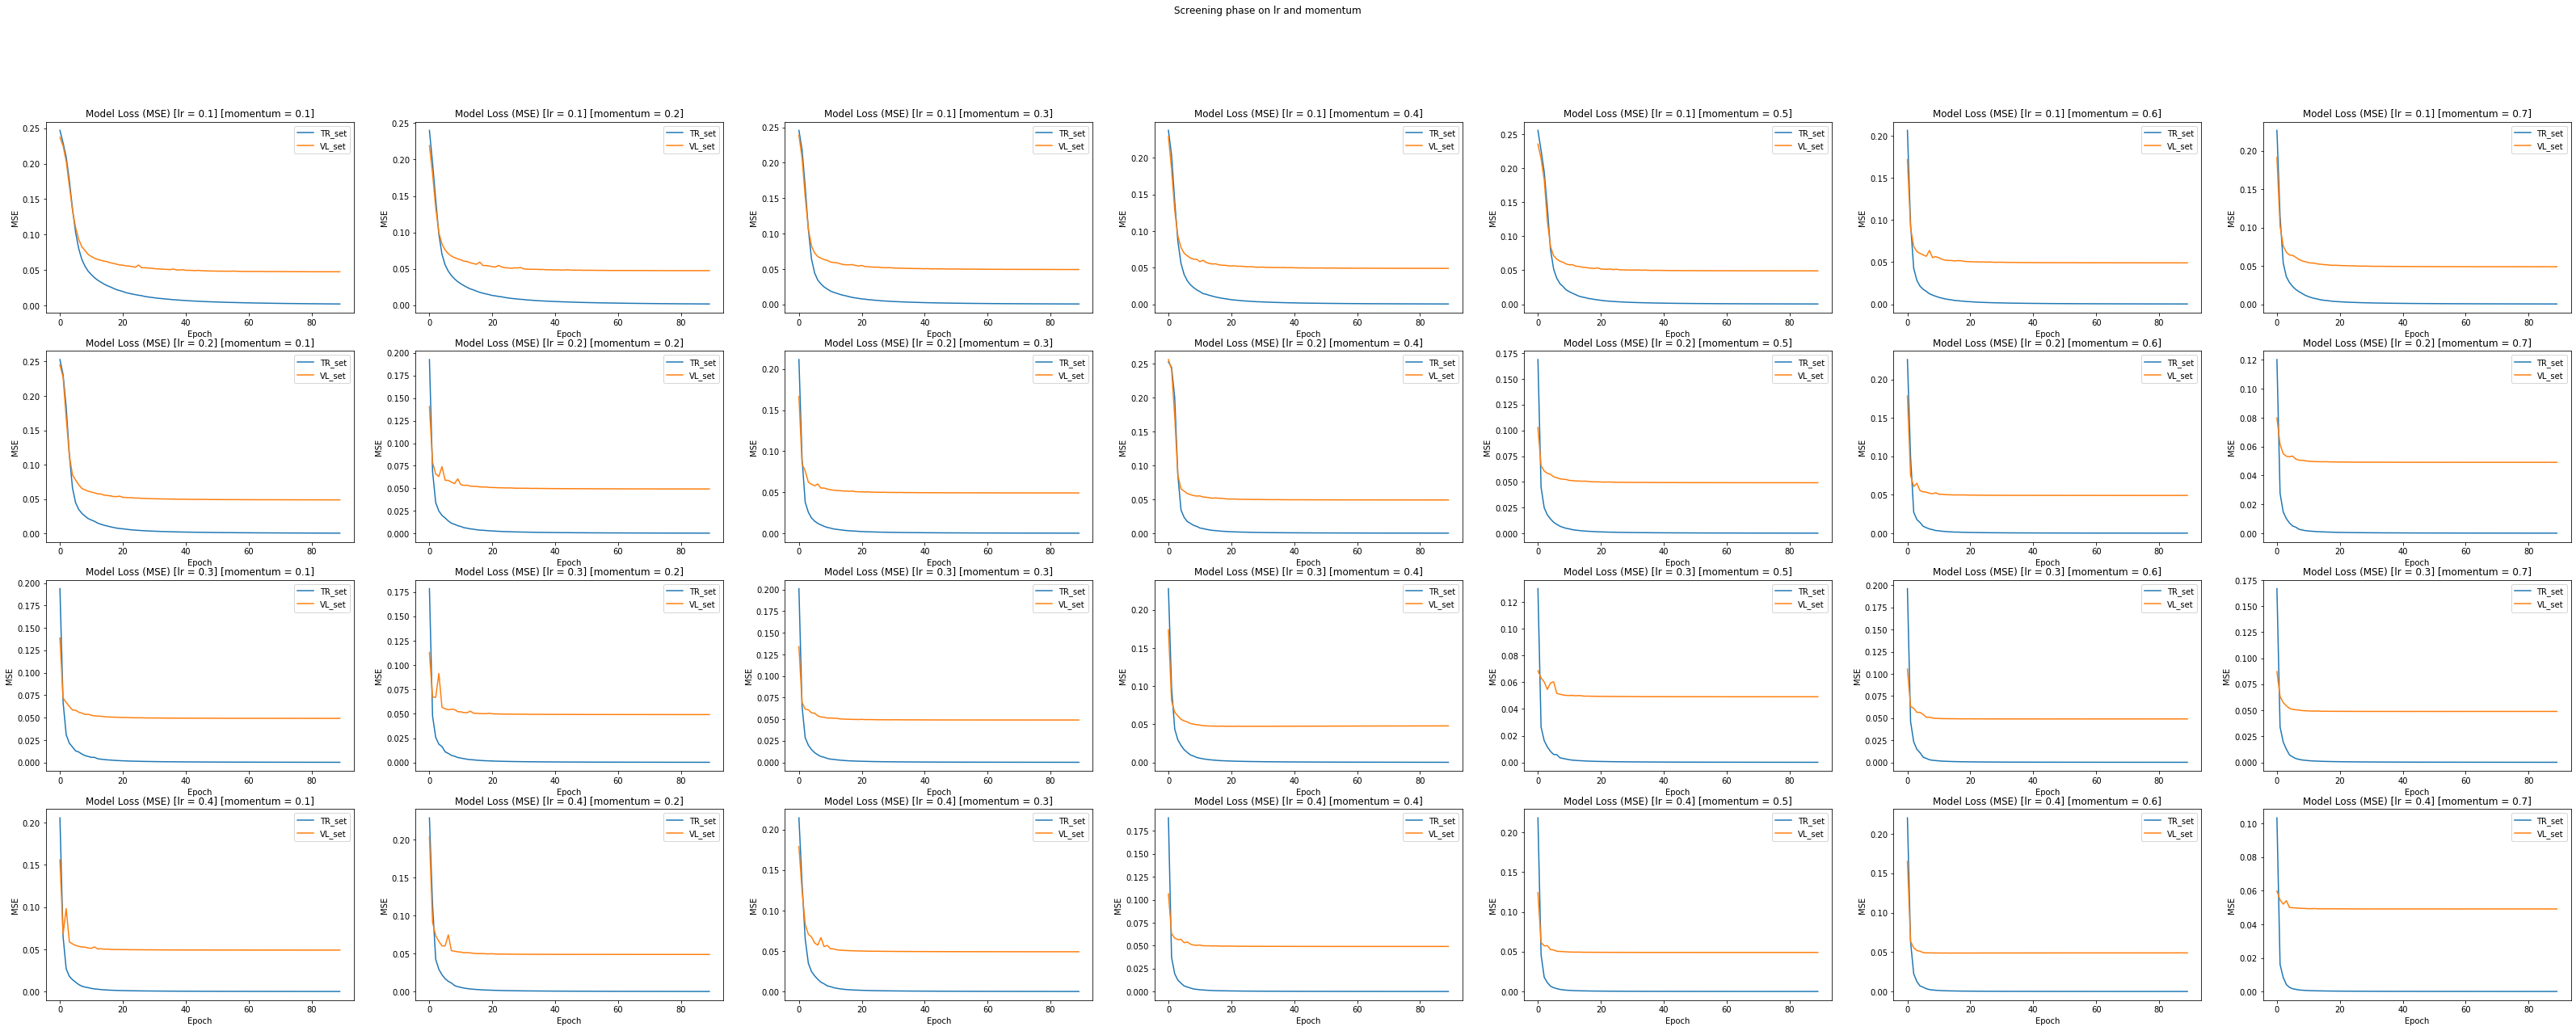

In [16]:
screening_phase('lr', [0.1,0.2,0.3,0.4], 'momentum', [0.1,0.2,0.3,0.4,0.5,0.6,0.7])

In [95]:
# define the grid search parameters
param_grid_1 = {}
param_grid_1['lr'] = [0.1, 0.4, 0.7]
param_grid_1['momentum'] = [0.1, 0.4, 0.7]
param_grid_1['num_hidden_units'] = [2,3,4]
param_grid_1['num_hidden_units2'] = [2,3,4]
param_grid_1['activation_hidden'] = ['relu', 'sigmoid', 'tanh']
param_grid_1['activation_hidden2'] = ['relu', 'sigmoid', 'tanh']
param_grid_1['activation_out'] = ['tanh','sigmoid']
param_grid_1['epochs'] = [90,120] 
param_grid_1['batch_size'] = [10] 

In [96]:
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=1)

In [ ]:
start=time()
model = KerasClassifier(build_fn=create_model) 
grid = GridSearchCV(estimator=model, param_grid=param_grid_1,n_jobs=-1,cv=cv,verbose=1) 
grid_result = grid.fit(one_hot_train, train_label)
end=time() 
print("Total Running Time: %f",end-start)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Mean\tSTD\tParams")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 2916 candidates, totalling 5832 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 27.1min


Total Running Time: %f 416.9085144996643
Best: 1.000000 using {'activation_hidden': 'sigmoid', 'activation_out': 'sigmoid', 'batch_size': 10, 'epochs': 50, 'lr': 0.1, 'momentum': 0.7, 'num_hidden_units': 2}

In [89]:
model = Sequential()
initializer = initializers.GlorotNormal(seed = 1) # seed to produce the same random sample.
model.add(Dense(units=2, kernel_initializer=initializer,input_dim=17, activation='sigmoid'))
# model.add(Dropout(0.2))
# model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr= 0.1, momentum=0.1, nesterov=False)
model.compile(optimizer=sgd, loss='mean_squared_error',metrics=['accuracy'])
history = model.fit(one_hot_train, train_label,validation_data=(one_hot_test, test_label),callbacks=[early_stopping], epochs= 90, batch_size=10, verbose=1)

Epoch 1/90
44/44 [==============================] - 0s 4ms/step - loss: 0.2582 - accuracy: 0.5278 - val_loss: 0.2573 - val_accuracy: 0.4918
Epoch 2/90
44/44 [==============================] - 0s 2ms/step - loss: 0.2420 - accuracy: 0.5278 - val_loss: 0.2430 - val_accuracy: 0.5000
Epoch 3/90
44/44 [==============================] - 0s 2ms/step - loss: 0.2341 - accuracy: 0.5741 - val_loss: 0.2360 - val_accuracy: 0.6066
Epoch 4/90
44/44 [==============================] - 0s 2ms/step - loss: 0.2282 - accuracy: 0.6713 - val_loss: 0.2304 - val_accuracy: 0.6721
Epoch 5/90
44/44 [==============================] - 0s 2ms/step - loss: 0.2221 - accuracy: 0.7431 - val_loss: 0.2259 - val_accuracy: 0.6311
Epoch 6/90
44/44 [==============================] - 0s 2ms/step - loss: 0.2150 - accuracy: 0.7153 - val_loss: 0.2189 - val_accuracy: 0.6557
Epoch 7/90
44/44 [==============================] - 0s 2ms/step - loss: 0.2070 - accuracy: 0.7384 - val_loss: 0.2107 - val_accuracy: 0.7787
Epoch 8/90
44/44 [==

In [66]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

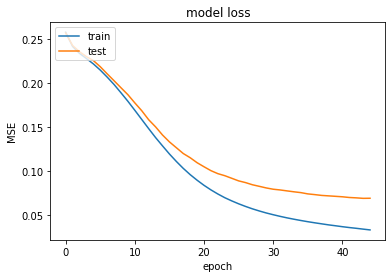

In [90]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('monk-2-learning curve')
plt.show()